In [1]:
# running geneformer and deepSem
import anndata as ad
import torch
import scanpy as sc

from bengrn import BenGRN, get_perturb_gt

from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2

FOLDER = "../../../Geneformer/"
NUM_GENES=5000


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import requests

# Create a directory to store the downloaded files
os.makedirs("../../data/human_dcm_hcm_nf", exist_ok=True)

# URLs for the files to download
base_url = "https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/resolve/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset/"
files_to_download = ["dataset.arrow", "dataset_info.json", "state.json"]

# Download the files
for file in files_to_download:
    url = base_url + file
    output_path = os.path.join("../../data/human_dcm_hcm_nf", file)
    
    if not os.path.exists(output_path):
        print(f"Downloading {file}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                f.write(response.content)
            print(f"\nDownloaded {file} to {output_path}")
        else:
            print(f"Failed to download {file}. Status code: {response.status_code}")
    else:
        print(f"{file} already exists in {output_path}")

print("Download complete!")


dataset.arrow already exists in ../../data/human_dcm_hcm_nf/dataset.arrow
dataset_info.json already exists in ../../data/human_dcm_hcm_nf/dataset_info.json
state.json already exists in ../../data/human_dcm_hcm_nf/state.json
Download complete!


In [ ]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]

    adata.write_h5ad("test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "../../data/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("./", 
                    "../../data/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "../../data/tokenized_data.dataset/",
                          "../../data/",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(subadata.copy(), grn=avg_attentions.to("cpu").numpy())

In [41]:
genes = torch.load('../../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

/tmp/ipykernel_2156367/1970222934.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  genes = torch.load('../../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_paramete

In [9]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var['ensembl_id'] = adata.var.index
adata.obs['n_counts'] = adata.X.sum(1)
adata.var["isTF"].sum()

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:624: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs["organism_ontology_term_id"] = "NCBITaxon:9606"


650

In [48]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
subadata = adata[:, adata.var.index.isin(genes) & adata.var.highly_variable]


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


precision:  0.020716123354900872 
recall:  1.0 
random precision: 0.020720489581800353


 98%|█████████▊| 126/128 [00:05<00:00, 23.21it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:05<00:00, 23.76it/s]


Average Precision (AP):  0.03665993889917633
Area Under Precision-Recall Curve (AUPRC):  0.03653789806596354
EPR: 2.3564197261419393


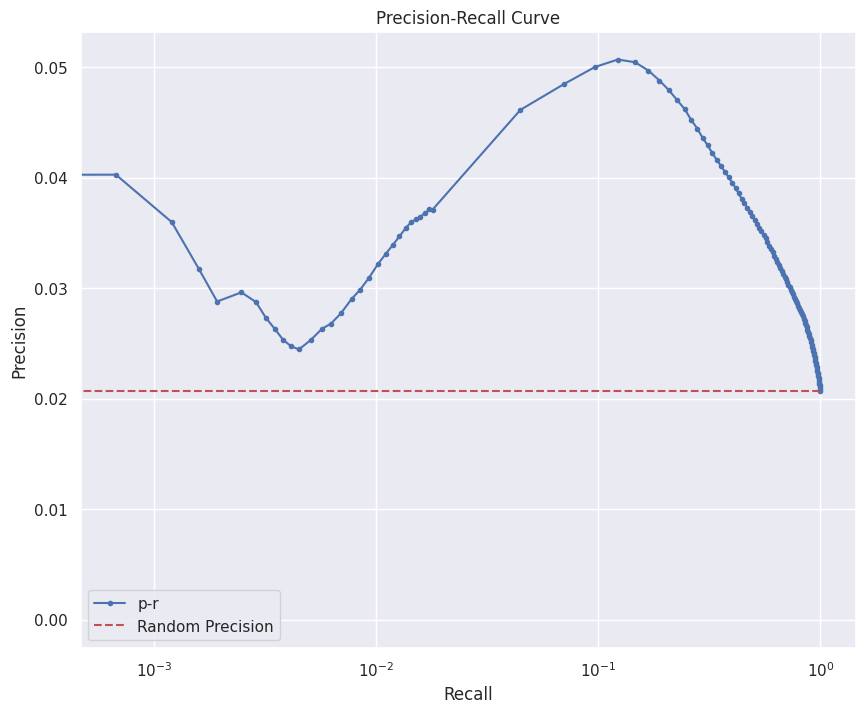

{'precision': 0.020716123354900872,
 'recall': 1.0,
 'rand_precision': 0.020720489581800353,
 'auprc': 0.03653789806596354,
 'ap': 0.03665993889917633,
 'epr': 2.3564197261419393}

In [10]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

precision:  0.021978226708821876 
recall:  1.0 
random precision: 0.021984053386104173


 99%|█████████▉| 127/128 [00:03<00:00, 37.23it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:03<00:00, 33.32it/s]


Average Precision (AP):  0.03839641033738078
Area Under Precision-Recall Curve (AUPRC):  0.0382545270712772
EPR: 2.382353098217213


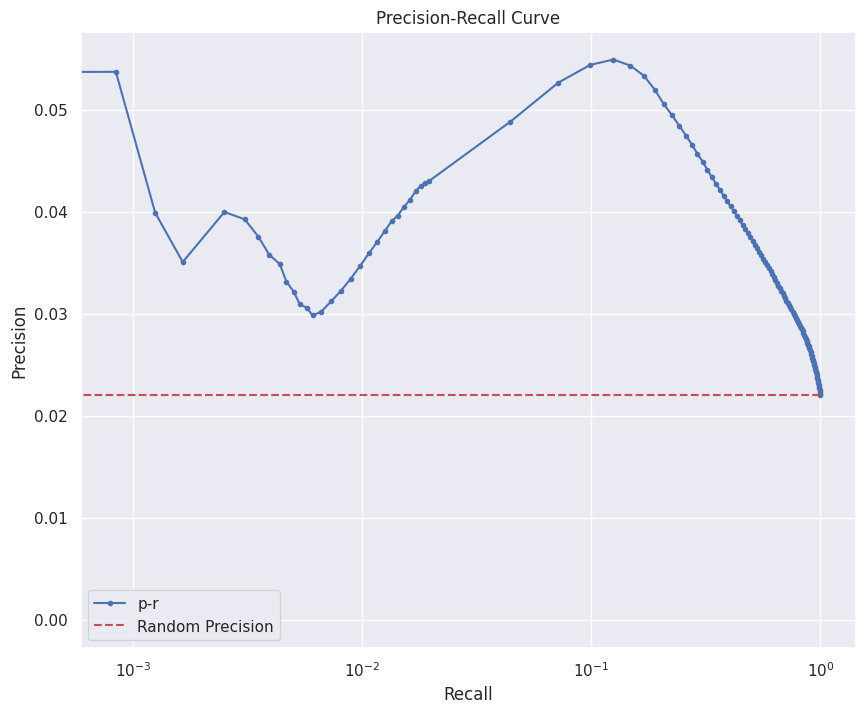

{'precision': 0.021978226708821876,
 'recall': 1.0,
 'rand_precision': 0.021984053386104173,
 'auprc': 0.0382545270712772,
 'ap': 0.03839641033738078,
 'epr': 2.382353098217213}

In [33]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)